In [171]:
from free_lie_algebra import *
from logsignature import *

import numpy as np
from random import randrange
from esig import tosig
import iisignature

from random import randrange
from random import seed

from urllib.request import urlopen

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

import matplotlib.pyplot as plt
from itertools import cycle

In [258]:
# url
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"

# Load data
def load_pendigits(url=url):
    class Digit:
        def __init__(self, points, digit):
            self.points=points
            self.digit=digit
    data = urlopen(url)
    digits=[]
    for line in data:
        digitList=line.decode("utf-8").replace(",", " ").replace("\n", "").split()
        number=float(digitList[16])
        points=np.array([[float(digitList[i]), float(digitList[i+1])]
                        for i in range(0,len(digitList)-1, 2)])
        digit=Digit(points, number)
        digits.append(digit)
    X = [digit.points/100. for digit in digits]
    y = [int(digit.digit) for digit in digits]   
    return X, y

#depth of signatures
depth = 2

# calculate signatures
def get_signatures(X, y, depth=depth):
#     sigs = [tosig.stream2sig(p, depth) for p in X]
    sigs = [signature_of_path_iisignature(p, depth) for p in X]
    return sigs, y

# get final dataset
def get_dataset(sig_depth=depth):
    X_pen, y = load_pendigits()
    X_sig, y = get_signatures(X_pen, y, depth=sig_depth)
    return [(x, k) for x, k in zip(X_sig, y)]

In [261]:
# inner product for distance
def inner_product(sig1, sig2, depth=depth, width=2):
    out=0.
    ind1 = 1  
    for k in range(1, depth+1):
        ind2 = width**(k+1)-1
        for x, y in zip(sig1[ind1:ind2], sig2[ind1:ind2]):
            out += x*y
        ind1 = ind2
    return out

# distance
def sig_distance(row1, row2):
#     d = row1[0] - row2[0]
#     return math.sqrt(inner_product(d, d))
    return distance(row1[0], row2[0])

# Locate the best matching unit
def get_best_matching_unit(nodes, test_row):
    distances = [(n, sig_distance(n, test_row)) for n in nodes]
    distances.sort(key=lambda tup: tup[1])
    return distances[0][0]

In [106]:
def sig_scale(sig, scale, depth=depth, width=2):
    ind1 = 1  
    for k in range(1, depth+1):
        ind2 = width**(k+1)-1
        sig[ind1:ind2] = sig[ind1:ind2]*(scale**k)
        ind1 = ind2
    return sig

In [107]:
# Create a random codebook vector
def random_codebook(train):
    codebook = []
    for s in range(10):
        data = [x for x in train if x[1]==s]
        codebook.append(data[randrange(len(data))])
    return codebook

In [271]:
# Train a set of codebook vectors
def train_codebooks(train, lrate, epochs):
    nodes = random_codebook(train)
    for epoch in range(epochs):
        rate = lrate * (1.0-(float(epoch)/float(epochs)))
        sum_error = 0.
        for row in train:
            bmu = get_best_matching_unit(nodes, row)
            error = sig_distance(row, bmu)
            sum_error += error**2
            if bmu[1] == row[1]:
#                 nodes[bmu[1]] = (bmu[0] + sig_scale(row[0] - bmu[0], rate), bmu[1])
#                 nodes[bmu[1]] = (bmu[0] + rate*(row[0] - bmu[0]), bmu[1])
                nodes[bmu[1]] = (exp(log(bmu[0], depth) + rate*(log(row[0], depth) - log(bmu[0], depth)), depth), bmu[1])
#             else:
#                 nodes[bmu[1]] = (bmu[0] - sig_scale(row[0] - bmu[0], rate), bmu[1])
#                 nodes[bmu[1]] = (bmu[0] - rate*(row[0] - bmu[0]), bmu[1])
#                 nodes[bmu[1]] = (exp(log(bmu[0], depth) - rate*(log(row[0], depth) - log(bmu[0], depth)), depth), bmu[1])

        sum_error /= len(train)
        if epoch % 5 == 0:
            print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, rate, sum_error))
    return nodes

In [272]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Split a dataset into k folds
def cross_validation_split(data, n_folds):
    dataset_split = list()
    dataset_copy = list(data)
    fold_size = int(len(data) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [273]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(data, algorithm, n_folds, *args):
    folds = cross_validation_split(data, n_folds)
    scores = list()
    for i in range(len(folds)):
        fold = folds[i]
        ll = list(range(len(folds)))
        ll.remove(i)
        train_set = [folds[k] for k in ll]
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Make a prediction with codebook vectors
def predict(codebooks, test_row):
    bmu = get_best_matching_unit(codebooks, test_row)
    return bmu[1]

# LVQ Algorithm
def learning_vector_quantization(train, test, lrate, epochs):
    codebooks = train_codebooks(train, lrate, epochs)
    predictions = list()
    for row in test:
        output = predict(codebooks, row)
        predictions.append(output)
    return(predictions)

In [274]:
def decision_score(codebooks, test_row):
    y_score = [0.]*10
    digit_class = predict(codebooks, test_row)
    y_score[digit_class] = 1.
    return np.array(y_score)

def decision_function(codebooks, data_test):
    return np.array([decision_score(codebooks, test_row) for test_row in data_test])

In [275]:
# load data
dataset = get_dataset(sig_depth=2)

In [279]:
# split train test
data_train, data_test = train_test_split(dataset, test_size = 0.2, random_state = 42)

# train LVQ
learn_rate = 0.3
n_epochs = 500
codebooks = train_codebooks(data_train, learn_rate, n_epochs)

>epoch=0, lrate=0.300, error=0.166
>epoch=5, lrate=0.297, error=0.170
>epoch=10, lrate=0.294, error=0.170
>epoch=15, lrate=0.291, error=0.170
>epoch=20, lrate=0.288, error=0.170
>epoch=25, lrate=0.285, error=0.170
>epoch=30, lrate=0.282, error=0.169
>epoch=35, lrate=0.279, error=0.169
>epoch=40, lrate=0.276, error=0.166
>epoch=45, lrate=0.273, error=0.166
>epoch=50, lrate=0.270, error=0.166
>epoch=55, lrate=0.267, error=0.165
>epoch=60, lrate=0.264, error=0.165
>epoch=65, lrate=0.261, error=0.166
>epoch=70, lrate=0.258, error=0.165
>epoch=75, lrate=0.255, error=0.165
>epoch=80, lrate=0.252, error=0.165
>epoch=85, lrate=0.249, error=0.165
>epoch=90, lrate=0.246, error=0.165
>epoch=95, lrate=0.243, error=0.165
>epoch=100, lrate=0.240, error=0.165
>epoch=105, lrate=0.237, error=0.164
>epoch=110, lrate=0.234, error=0.164
>epoch=115, lrate=0.231, error=0.164
>epoch=120, lrate=0.228, error=0.164
>epoch=125, lrate=0.225, error=0.164
>epoch=130, lrate=0.222, error=0.164
>epoch=135, lrate=0.219

In [280]:
# binarize labels for ROC curve
y_test = label_binarize(np.array([x[1] for x in data_test]), classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# compute probabilities
y_score = decision_function(codebooks, data_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=10
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

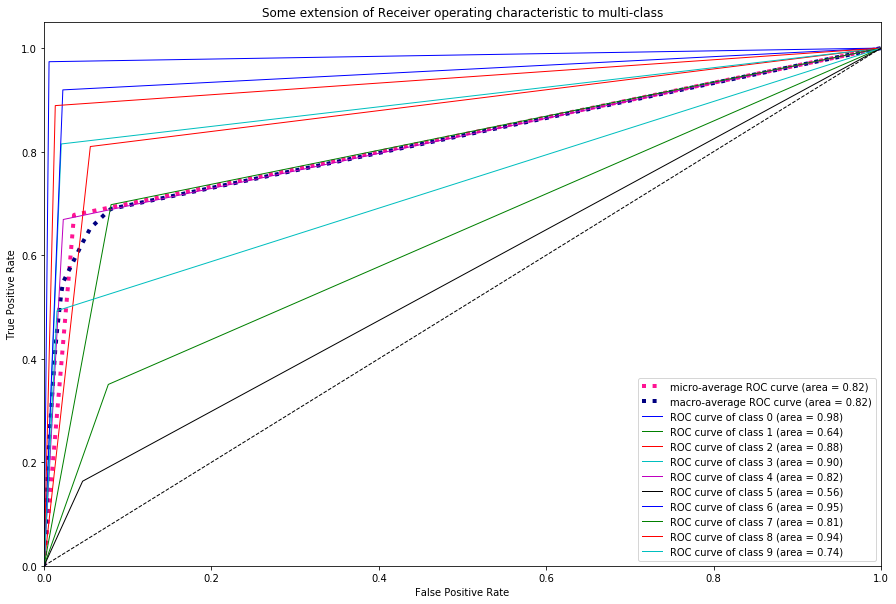

In [281]:
# Plot all ROC curves
lw=1
plt.figure(figsize=(15, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle('bgrcmk')
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [190]:
# Test LVQ on pendigits dataset

# load data
dataset = get_dataset(sig_depth=2)

# evaluate algorithm
n_folds = 5
learn_rate = 0.1
n_epochs = 5
scores = evaluate_algorithm(dataset, 
                            learning_vector_quantization, 
                            n_folds, learn_rate, n_epochs)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

>epoch=0, lrate=0.100, error=1998.568
>epoch=1, lrate=0.080, error=1977.211
>epoch=2, lrate=0.060, error=1966.648
>epoch=3, lrate=0.040, error=1956.945
>epoch=4, lrate=0.020, error=1947.849
>epoch=0, lrate=0.100, error=1990.401
>epoch=1, lrate=0.080, error=1964.814
>epoch=2, lrate=0.060, error=1953.255
>epoch=3, lrate=0.040, error=1944.014
>epoch=4, lrate=0.020, error=1934.401
>epoch=0, lrate=0.100, error=1995.402
>epoch=1, lrate=0.080, error=1971.327
>epoch=2, lrate=0.060, error=1959.529
>epoch=3, lrate=0.040, error=1949.637
>epoch=4, lrate=0.020, error=1941.326
>epoch=0, lrate=0.100, error=2039.239
>epoch=1, lrate=0.080, error=1981.111
>epoch=2, lrate=0.060, error=1969.988
>epoch=3, lrate=0.040, error=1959.778
>epoch=4, lrate=0.020, error=1950.314
>epoch=0, lrate=0.100, error=2003.763
>epoch=1, lrate=0.080, error=1981.810
>epoch=2, lrate=0.060, error=1970.899
>epoch=3, lrate=0.040, error=1960.151
>epoch=4, lrate=0.020, error=1951.517
Scores: [68.55807743658211, 69.02536715620828, 42.